## Предсказываем тональность постов


In [1]:
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import numpy as np

Загрузим обучающий и тестовый датасет постов: 

In [2]:
train_df = pd.read_csv("../../../data/Corona_NLP_train.csv.zip",encoding='latin-1')
test_df = pd.read_csv("../../../data/Corona_NLP_test.csv.zip",encoding='latin-1')
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


Посмотрим на различные возможные значения `Sentiment`:

<AxesSubplot:>

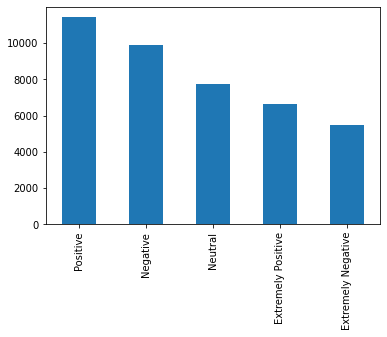

In [3]:
train_df['Sentiment'].value_counts().plot.bar()

Для преобразования тональнсти в число от 0 до 5 используем словарь:

In [4]:
classes = ['Extremely Negative','Negative','Neutral','Positive','Extremely Positive']
cls_dict = { k : i for i,k in enumerate(classes) }

In [5]:
train_x = train_df['OriginalTweet']
train_y = train_df['Sentiment'].apply(lambda x: cls_dict[x])
test_x = test_df['OriginalTweet']
test_y = test_df['Sentiment'].apply(lambda x: cls_dict[x])

Для извлечения вектора TF-IDF из текста используем `TextVectorization`, и адаптируем его для нашего датасета:

In [10]:
#vect = keras.layers.experimental.preprocessing.TextVectorization(output_mode='tf-idf')
vect = keras.layers.experimental.preprocessing.TextVectorization(output_mode='tf-idf',max_tokens=10000)

vect.adapt(train_x)

In [11]:
model = keras.models.Sequential([
    vect,
    keras.layers.Dense(len(classes),activation='softmax')
])
model.compile('adam','sparse_categorical_crossentropy',['acc'])

In [12]:
model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=5,shuffle=True)

Epoch 1/5
1287/1287 [==============================] - 40s 31ms/step - loss: 1.2383 - acc: 0.4811 - val_loss: 1.1336 - val_acc: 0.5445. - ETA: 4s - - ETA: 2
Epoch 2/5
1287/1287 [==============================] - 37s 28ms/step - loss: 0.8227 - acc: 0.7034 - val_loss: 1.1301 - val_acc: 0.5635
Epoch 3/5
1287/1287 [==============================] - 41s 32ms/step - loss: 0.6856 - acc: 0.7582 - val_loss: 1.1646 - val_acc: 0.5685
Epoch 4/5
1287/1287 [==============================] - 38s 29ms/step - loss: 0.6024 - acc: 0.7931 - val_loss: 1.2001 - val_acc: 0.5732
Epoch 5/5
1287/1287 [==============================] - 37s 29ms/step - loss: 0.5455 - acc: 0.8128 - val_loss: 1.2670 - val_acc: 0.5761


In [13]:
vocab = vect.get_vocabulary()
for i in range(5):
    print(f"==={train_x[i]}===")
    v = vect(train_x[i])
    for j,x in enumerate(vocab):
        if v[j]>0:
            print(f"{x} -> {v[j]}")

===@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8===
[UNK] -> 44.5999755859375
and -> 2.4190921783447266
===advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order===
[UNK] -> 7.433329105377197
to -> 2.003671169281006
of -> 2.5323829650878906
with -> 2.0580949783325195
your -> 2.4789364337921143
not -> 2.415011405944824
up -> 2.541259527206421
shopping -> 2.5787179470062256
but -> 2.5800867080688477
if -> 2.6124637126922607
online -> 2.656214952468872
over -> 3.44028639793396
supplies -> 3.9622442722320557
order -> 4.226402759552002
family -> 4.352114200592041
list -> 4.770034313201904
contact -> 4.88652229309082
set -> 4.9691619873046875
advice -> 5.059365272521973
phone -> 11.290167808532715
talk -> 5.618152141571045
regular -> 5.78404331207

In [33]:
vect = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=3000,output_mode='tf-idf')
vect.adapt(train_x)
model = keras.models.Sequential([
    vect,
    keras.layers.Lambda(lambda x: x[:,2:]),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(len(classes),activation='softmax')
])
model.compile('adam','sparse_categorical_crossentropy',['acc'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_10 (TextV (None, 3000)              1         
_________________________________________________________________
lambda_8 (Lambda)            (None, 2998)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                29990     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 55        
Total params: 30,046
Trainable params: 30,045
Non-trainable params: 1
_________________________________________________________________


In [34]:
model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=5,shuffle=True)

Epoch 1/5
1287/1287 [==============================] - 13s 10ms/step - loss: 1.2130 - acc: 0.4886 - val_loss: 1.0410 - val_acc: 0.5990: 1.2280 
Epoch 2/5
1287/1287 [==============================] - 15s 12ms/step - loss: 0.8805 - acc: 0.6748 - val_loss: 1.0252 - val_acc: 0.6022
Epoch 3/5
1287/1287 [==============================] - 13s 10ms/step - loss: 0.7853 - acc: 0.7164 - val_loss: 1.0406 - val_acc: 0.6132
Epoch 4/5
1287/1287 [==============================] - 13s 10ms/step - loss: 0.7155 - acc: 0.7442 - val_loss: 1.0886 - val_acc: 0.6085
Epoch 5/5
1287/1287 [==============================] - 11s 9ms/step - loss: 0.6647 - acc: 0.7613 - val_loss: 1.1390 - val_acc: 0.5937


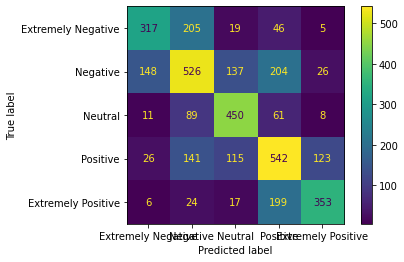

In [20]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,mean_absolute_percentage_error
pred_y = tf.argmax(model(test_x),axis=1)
ConfusionMatrixDisplay(confusion_matrix(test_y,pred_y),display_labels=classes).plot()

In [55]:
vect = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=2000,output_mode='tf-idf')
vect.adapt(train_x)
model = keras.models.Sequential([
    vect,
    keras.layers.Lambda(lambda x: x[:,2:]),
    keras.layers.Dense(1,activation=None)
])
model.compile('adam','mse',['mae'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_10 (TextV (None, 2000)              1         
_________________________________________________________________
lambda_6 (Lambda)            (None, 1998)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1999      
Total params: 2,000
Trainable params: 1,999
Non-trainable params: 1
_________________________________________________________________


In [56]:
model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=5,shuffle=True)

Epoch 1/5
1287/1287 [==============================] - 6s 4ms/step - loss: 1.4141 - mae: 0.9547 - val_loss: 1.0231 - val_mae: 0.8056
Epoch 2/5
1287/1287 [==============================] - 5s 4ms/step - loss: 0.8675 - mae: 0.7333 - val_loss: 0.9400 - val_mae: 0.7593
Epoch 3/5
1287/1287 [==============================] - 5s 4ms/step - loss: 0.7878 - mae: 0.6889 - val_loss: 0.9025 - val_mae: 0.7367
Epoch 4/5
1287/1287 [==============================] - 5s 4ms/step - loss: 0.7520 - mae: 0.6666 - val_loss: 0.8807 - val_mae: 0.7238
Epoch 5/5
1287/1287 [==============================] - 5s 4ms/step - loss: 0.7386 - mae: 0.6570 - val_loss: 0.8714 - val_mae: 0.7173


In [80]:
pred_y = model(test_x)[:,0]
np.mean(np.abs(test_y-pred_y))/np.mean(pred_y)

0.356662157213274